# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg, countDistinct, round
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
import datetime
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
from pyspark.ml.feature import RegexTokenizer, VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit,CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier, GBTClassifier, LinearSVC


In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Capstone Project") \
    .getOrCreate()


# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
df = spark.read.json("mini_sparkify_event_data.json")

In [4]:
#getting a basic overview
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
df.take(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9')]

In [6]:
df.toPandas().shape

(286500, 18)

In [7]:
#check if we have nan values
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



We don't have any nan values

In [8]:
#check if we have null values
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



We do have null values, numbers suggest that a lot of them might be in the same rows

In [9]:
#check if we have empty values
df.select([count(when(col(c)=='', c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|  8346|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [10]:
#removing rows with empty values
df=df.where("userId!=''")

In [11]:
df.toPandas().shape

(278154, 18)

In [12]:
#check what columns have remaining null values
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 50046|   0|        0|     0|            0|       0| 50046|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [13]:
df.where(df.artist.isNull()).show()

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|           page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Logged In|    Colin|     M|           54| Freeman|  null| paid|     Bakersfield, CA|   PUT|Add to Playlist|1538173362000|       29|null|   200|1538352905000|Mozilla/5.0 (Wind...|    30|
|  null|Logged In|    Micah|     M|           84|    Long|  null| free|Boston-Cambridge-...|   GET|    Roll Advert|1538331630000|        8|null|   200|1538353150000|"Mozilla/5.0 (Win...|     9|
|  null|Logged In|    Micah|  

Depending on the page the user is on, we don't always have a song, so these missing values make sense, I guess.

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

Defining two plotting functions

In [14]:
def get_barchart(df,plotname="default"):
    '''
    df: a pyspark df of 2 columns, with second one being the count
    plotname: plot title
    '''
    pd_df=df.toPandas()

    y_pos=np.arange(len(pd_df[pd_df.columns[0]]))
    ax = pd_df.plot(kind='bar', figsize=(5,5));
    ax.set_title("{}".format(plotname))
    ax.set_ylabel("Count")

    return ax

In [15]:
def get_groupedbarchart(df_g,grouparray):
    '''
    df_g: a pyspark df of 2 columns, with second one being the count
    grouparray: sorted bar names
    '''
    barWidth = 0.25
    #choose bar values
    bars1 = list(df_g.where(df_g.churn=="0").select('normalized').toPandas()['normalized'])
    bars2 = list(df_g.where(df_g.churn=="1").select('normalized').toPandas()['normalized'])
    # Set position of bar on X axis
    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]
    # plot
    plt.bar(r1, bars1, color='green', width=barWidth, edgecolor='white', label='non-churn')
    plt.bar(r2, bars2, color='blue', width=barWidth, edgecolor='white', label='churn')


    # Add xticks on the middle of the group bars
    plt.xlabel('group', fontweight='bold')
    plt.xticks([r+barWidth/2 for r in range(len(bars1))], grouparray)

    plt.legend()
    plt.show()

introducing churn column

In [16]:
#flag event
cancel_event=udf(lambda x: 1 if x=='Cancellation Confirmation' else 0, IntegerType())
df=df.withColumn("churn",cancel_event(df.page))

In [17]:
#flag users that cancelled - cancellation event should be last interaction of the userID
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
df = df.withColumn("churn", Fsum("churn").over(windowval))

In [18]:
df.take(2)

[Row(artist=None, auth='Logged In', firstName='Darianna', gender='F', itemInSession=34, lastName='Carpenter', length=None, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0),
 Row(artist='Lily Allen', auth='Logged In', firstName='Darianna', gender='F', itemInSession=33, lastName='Carpenter', length=185.25995, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=187, song='22', status=200, ts=1542823951000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0)]

In [19]:
#look at the number of users who did/did not cancel
df.groupby("churn").agg(countDistinct("userID")).show()

+-----+----------------------+
|churn|count(DISTINCT userID)|
+-----+----------------------+
|    0|                   173|
|    1|                    52|
+-----+----------------------+



out of the 225 users we are looking at in this reduced dataset, 52 have cancelled their membership

In [20]:
df.where(df.page=='Cancellation Confirmation').take(2)

[Row(artist=None, auth='Cancelled', firstName='Mason', gender='M', itemInSession=10, lastName='Hart', length=None, level='free', location='Corpus Christi, TX', method='GET', page='Cancellation Confirmation', registration=1533157139000, sessionId=174, song=None, status=200, ts=1539318918000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='125', churn=1),
 Row(artist=None, auth='Cancelled', firstName='Ethan', gender='M', itemInSession=176, lastName='Johnson', length=None, level='paid', location='Lexington-Fayette, KY', method='GET', page='Cancellation Confirmation', registration=1538080987000, sessionId=934, song=None, status=200, ts=1539761972000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='51', churn=1)]

Take a closer look at how data is distributed 

In [21]:
#overview on numerical columns
df.toPandas().describe()

,itemInSession,length,registration,sessionId,status,ts,churn
count,278154.000000,228108.000000,2.781540e+05,278154.000000,278154.000000,2.781540e+05,278154.000000
mean,114.899182,249.117182,1.535359e+12,1042.561624,209.103216,1.540959e+12,0.161292
std,129.851729,99.235179,3.291322e+09,726.501036,30.151389,1.506829e+09,0.367801
min,0.000000,0.783220,1.521381e+12,1.000000,200.000000,1.538352e+12,0.000000
25%,27.000000,199.888530,1.533522e+12,338.000000,200.000000,1.539699e+12,0.000000
50%,70.000000,234.500770,1.536664e+12,1017.000000,200.000000,1.540934e+12,0.000000
75%,157.000000,277.158730,1.537672e+12,1675.000000,200.000000,1.542268e+12,0.000000
max,1321.000000,3024.665670,1.543247e+12,2474.000000,404.000000,1.543799e+12,1.000000


In [22]:
#number of different status values
df.agg(countDistinct("status")).show()

+----------------------+
|count(DISTINCT status)|
+----------------------+
|                     3|
+----------------------+



In [23]:
#number of different useragent values
df.agg(countDistinct("userAgent")).show()

+-------------------------+
|count(DISTINCT userAgent)|
+-------------------------+
|                       56|
+-------------------------+



In [24]:
#visited pages
df.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



several interesting pages, will look into "thumbs up" and "thumbs down" later on

In [25]:
#get actions by hour of day
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
df = df.withColumn("hour", get_hour(df.ts))

In [26]:
#get actions by weekday
get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%w"))
df = df.withColumn("weekday", get_weekday(df.ts))

In [27]:
#get actions by date
get_date = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%d-%m-%Y"))
df = df.withColumn("date", get_date(df.ts))

In [28]:
#get df for plot
df_hour=df.groupby(df.hour).count().orderBy(df.hour.cast("float"))

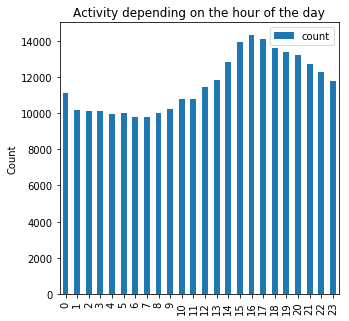

In [29]:
#plot activity over hours of the day
get_barchart(df_hour,'Activity depending on the hour of the day');

highest activity can be observed from late afternoon to about midnight

In [30]:
#get df to include churn into the plot
df_g=df.groupby(df.hour,df.churn).count().orderBy(df.hour.cast("float"))
#normalize
df_g = df_g.join(df_g.groupby('hour').sum('count').alias('weekday_sum'),"hour")
df_g = df_g.select('hour', 'churn', round(col('count')/col('sum(count)'), 2).alias('normalized'))

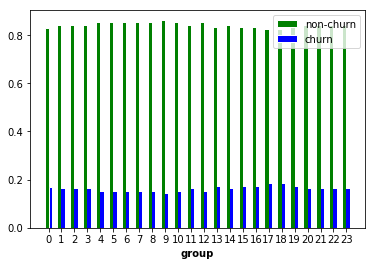

In [31]:
get_groupedbarchart(df_g,np.arange(24))

not a massive difference, but users that frequent sparkify from morning to early afternoon hours seem to have a lower churn rate

In [32]:
#get an overview on thumbs up/thumbs down per churn/non churn user group
df_vote=df.where((df.page=="Thumbs Up") | (df.page=="Thumbs Down")).groupby(df.page,df.churn).count().orderBy("page")
#normalize
df_vote = df_vote.join(df_vote.groupby('page').sum('count').alias('vote_count'),"page")
df_vote = df_vote.select('page', 'churn', round(col('count')/col('sum(count)'), 2).alias('normalized'))

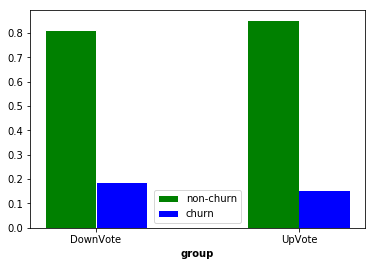

In [33]:
get_groupedbarchart(df_vote,["DownVote","UpVote"])

slightly lower churn percentage for people that gave "thumbs up" for songs

In [34]:
df.take(2)

[Row(artist=None, auth='Logged In', firstName='Darianna', gender='F', itemInSession=34, lastName='Carpenter', length=None, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0, hour='18', weekday='3', date='21-11-2018'),
 Row(artist='Lily Allen', auth='Logged In', firstName='Darianna', gender='F', itemInSession=33, lastName='Carpenter', length=185.25995, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=187, song='22', status=200, ts=1542823951000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', chur

taking a look at weekdays

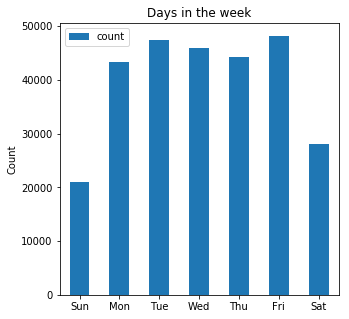

In [35]:
#get weekday df and plot
df_wd=df.groupby(df.weekday).count().orderBy(df.weekday.cast("float"))
ax= get_barchart(df_wd,"Days in the week")
ax= ax.set_xticklabels(['Sun','Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'], rotation=0);

lowest activity levels on the weekend

In [36]:
#get weekday df including churn segmentation
df_g=df.groupby(["weekday","churn"]).agg(countDistinct("userID")).orderBy(["weekday","churn"])
#normalize
df_g = df_g.join(df_g.groupby('weekday').sum('count(DISTINCT userID)').alias('weekday_sum'),"weekday")
df_g = df_g.select('weekday', 'churn', round(col('count(DISTINCT userID)')/col('sum(count(DISTINCT userID))'), 2).alias('normalized'))

In [37]:
df.groupby(["weekday","churn"]).agg(countDistinct("userID")).orderBy(["weekday","churn"]).show()

+-------+-----+----------------------+
|weekday|churn|count(DISTINCT userID)|
+-------+-----+----------------------+
|      0|    0|                   109|
|      0|    1|                    24|
|      1|    0|                   139|
|      1|    1|                    36|
|      2|    0|                   141|
|      2|    1|                    34|
|      3|    0|                   143|
|      3|    1|                    36|
|      4|    0|                   139|
|      4|    1|                    39|
|      5|    0|                   147|
|      5|    1|                    43|
|      6|    0|                   107|
|      6|    1|                    38|
+-------+-----+----------------------+



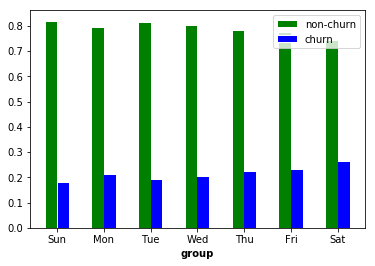

In [38]:
#plot weekday chart with churn rates
get_groupedbarchart(df_g,['Sun','Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])

churn rate for saturday users seems highest

Taking a look at gender distribution and potential effects on churn

In [39]:
df_count=df.groupby(["gender"]).agg(countDistinct("userID")).show()

+------+----------------------+
|gender|count(DISTINCT userID)|
+------+----------------------+
|     F|                   104|
|     M|                   121|
+------+----------------------+



In [40]:
#churn by gender
df_g=df.groupby(["gender","churn"]).agg(countDistinct("userID"))
#normalize
df_g = df_g.join(df_g.groupby('gender').sum('count(DISTINCT userID)').alias('gender_sum'),"gender")
df_g = df_g.select('gender', 'churn', round(col('count(DISTINCT userID)')/col('sum(count(DISTINCT userID))'), 2).alias('normalized'))

In [41]:
df_g.show()

+------+-----+----------+
|gender|churn|normalized|
+------+-----+----------+
|     F|    0|      0.81|
|     F|    1|      0.19|
|     M|    0|      0.74|
|     M|    1|      0.26|
+------+-----+----------+



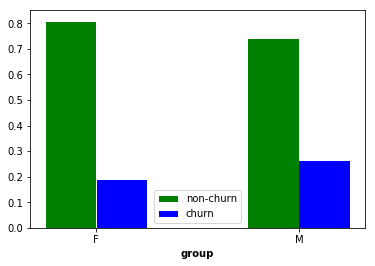

In [42]:
get_groupedbarchart(df_g,["F","M"])

male users have a slightly higher churn rate

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

As we have seen above we can choose from a large variety of different options, when it comes to the features we want to use.
I chose to go with:
- six numerical features (average items per session, average song length, number of friends added, number of songs played, number of thumbs up/down)
- one categorical feature (gender)

### Calculations of numerical features first

calculating the average items per session per user

In [43]:
#we don't want the number of page visits have an influence on the average of the played songs
per_session=df.groupby("userId","sessionId").max("itemInSession")
#calculate average
df_features=per_session.groupby("userId").avg("max(itemInSession)").select("userId",col("avg(max(itemInSession))").alias("avgItemsPerSession"))


average song length

In [44]:
#calculate avg length
avg_length=df.groupby("userId").avg("length").select("userId",col("avg(length)").alias("avgLength"))
#join with feature df
df_features=df_features.join(avg_length, "userId")

number of friends added

In [45]:
friend_count=df.where(df.page=='Add Friend').groupby("userId").count().select("userId",col("count").alias("friendCount"))
#join with feature df
df_features=df_features.join(friend_count, "userId")

number of songs played

In [46]:
per_session=df.groupby("userId","sessionId").max("itemInSession")
df_sum=per_session.groupby("userId").sum("max(itemInSession)").select("userId",col("sum(max(itemInSession))").alias("totalSongsPlayed"))
df_features=df_features.join(df_sum, "userId")

number of thumbs up and down

In [47]:
#get thumbs down
downV=df.where(df.page=='Thumbs Up').groupby("userId").count().select("userId",col("count").alias("upVote"))
#thumbs up
upV=df.where(df.page=='Thumbs Down').groupby("userId").count().select("userId",col("count").alias("downVote"))
#join with feature df
df_features=df_features.join(downV, "userId")
df_features=df_features.join(upV, "userId")

### Encoding categorical features

gender as a feature

In [48]:
#encode female as 0 and male as 1
gen=udf(lambda x: 0 if x=='F' else 1,IntegerType())
df_encoded=df.select("userId","gender",gen("gender").alias("gender_encoded")).select("userId","gender_encoded")

In [49]:
df_encoded=df_encoded.groupby("userId","gender_encoded").count()

In [50]:
#join dfs
df_features=df_features.join(df_encoded.select("userId","gender_encoded"), "userId")

In [51]:
df_features.show(10)

+------+------------------+------------------+-----------+----------------+------+--------+--------------+
|userId|avgItemsPerSession|         avgLength|friendCount|totalSongsPlayed|upVote|downVote|gender_encoded|
+------+------------------+------------------+-----------+----------------+------+--------+--------------+
|100010| 54.42857142857143|  243.421444909091|          4|             381|    17|       5|             0|
|200002|              80.0|242.91699209302305|          4|             480|    21|       6|             1|
|   124|170.13793103448276|248.17653659965674|         74|            4934|   171|      41|             0|
|    51|             251.9|247.88055082899118|         28|            2519|   100|      21|             1|
|     7|28.428571428571427| 253.5605806666668|          1|             199|     7|       1|             1|
|    15|154.86666666666667|249.37701452978064|         31|            2323|    81|      14|             1|
|    54| 94.21621621621621|250.385399

number of thumbs up & down

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

Will be trying out four different classifiers:
- logistic regression
- random forest classifier
- gradient-boosted tree classifier
- linear support vector machine

Get label column first

In [52]:
df_labels=df.groupby(["userId","churn"]).agg(countDistinct("userID")).select(col("userId"),col("churn").alias("label"))

In [53]:
df_labels.show()

+------+-----+
|userId|label|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
|     7|    0|
|    15|    0|
|    54|    1|
|   155|    0|
|100014|    1|
|   132|    0|
|   154|    0|
|   101|    1|
|    11|    0|
|   138|    0|
|300017|    0|
|100021|    1|
|    29|    1|
|    69|    0|
|   112|    0|
+------+-----+
only showing top 20 rows



In [54]:
#defining features
feat_cols=["avgItemsPerSession", "avgLength", "friendCount","totalSongsPlayed","gender_encoded","upVote","downVote"]

In [55]:
#vectorizing and normalizing the features
def vect_norm(df, columns):
    '''
    takes in two arguments:
    df: dataframe with data to vectorize and normalize
    columns: columns that will be considered
    returns a feature df
    '''
    assembler = VectorAssembler(inputCols=columns, outputCol="NumFeatures")
    df = assembler.transform(df)
    scaler = Normalizer(inputCol="NumFeatures", outputCol="features")
    df = scaler.transform(df)
    return df

In [56]:
#defining f1 score calculation
def get_f1_score(model,train_data,test_data):
    '''
    calculating the f1 score based on given
    model
    training data
    test data
    '''
    train_preds=model.transform(train_data)
    test_preds=model.transform(test_data)
    def _internal_calculations(predictions):
        true_neg=predictions.filter((predictions.label==0) & (predictions.prediction==0)).count()
        false_neg=predictions.filter((predictions.label==1) & (predictions.prediction==0)).count()
        true_pos=predictions.filter((predictions.label==1) & (predictions.prediction==1)).count()
        false_pos=predictions.filter((predictions.label==0) & (predictions.prediction==1)).count()

        try:
            precision=true_pos/(true_pos+false_pos)
        except ZeroDivisionError:
            return "no f1 score"
        recall=true_pos/(true_pos+false_neg)
        try:
            score=2*precision*recall/(precision+recall)
        except ZeroDivisionError:
            score="no f1 score"
            print("Cannot divide by 0")
        return score

    f1_train=_internal_calculations(train_preds)
    f1_test=_internal_calculations(test_preds)
    print("F1 train score: ",f1_train)
    print("F1 test score: ",f1_test)
    return 

In [57]:
df_norm=vect_norm(df_features,feat_cols)
#adding labels back in
df_norm=df_norm.join(df_labels,"userId")
df_norm=df_norm.select("features","label")

In [58]:
#splitting into train and test data
train, test = df_norm.randomSplit([0.8, 0.2], seed=42)


In [59]:
train.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: long (nullable = true)



**Logistic regression**

In [61]:
lr = LogisticRegression()
#define paramgrid
paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.01, 0.1]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5])\
    .build()#.addGrid(lr.fitIntercept, [False, True])\

#define crossvalidator
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                          numFolds=3)
#fit the model
lrmodel= crossval.fit(train)

In [62]:
#have a look at the first 10 predictions for our test set
lr_preds=lrmodel.transform(test)
lr_preds.select("label", "prediction","probability").show(10)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|    0|       0.0|[0.72905717607657...|
|    0|       0.0|[0.67818834680411...|
|    1|       0.0|[0.87225615527252...|
|    1|       0.0|[0.73773076761269...|
|    0|       0.0|[0.91129637265249...|
|    1|       0.0|[0.69126274948653...|
|    0|       0.0|[0.86595081159402...|
|    1|       0.0|[0.55931659151962...|
|    0|       0.0|[0.86982381810689...|
|    0|       0.0|[0.88824662776454...|
+-----+----------+--------------------+
only showing top 10 rows



In [63]:
get_f1_score(lrmodel,train,test)

Cannot divide by 0
F1 train score:  0.3111111111111111
F1 test score:  no f1 score


Seems like there was not a single churn prediction for the test data

In [64]:
lrmodel.bestModel.extractParamMap()

{Param(parent='LogisticRegression_176ef638899d', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2,
 Param(parent='LogisticRegression_176ef638899d', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.5,
 Param(parent='LogisticRegression_176ef638899d', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial.'): 'auto',
 Param(parent='LogisticRegression_176ef638899d', name='featuresCol', doc='features column name'): 'features',
 Param(parent='LogisticRegression_176ef638899d', name='fitIntercept', doc='whether to fit an intercept term'): True,
 Param(parent='LogisticRegression_176ef638899d', name='labelCol', doc='label column name'): 'label',
 Param(parent='LogisticRegression_176ef638899d', name='maxIter', doc='maximum number of iterations (>= 0)'): 

**Random forest**

In [65]:
rf = RandomForestClassifier(seed=42)
#define paramgrid for rf
paramGridrf = ParamGridBuilder()\
    .addGrid(rf.maxDepth, [4, 8]) \
    .addGrid(rf.numTrees, [15,30])\
    .build()
#define tvs
tvs2 = TrainValidationSplit(estimator=rf,
                           estimatorParamMaps=paramGridrf,
                           evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)
#fit the model
rfModel=tvs2.fit(train)

In [66]:
rf_preds = rfModel.transform(test)
rf_preds.select('label', 'prediction', 'probability').show(10)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|    0|       1.0|[0.36234174321583...|
|    0|       0.0|[0.69895974524025...|
|    1|       0.0|[0.87439209854637...|
|    1|       0.0|[0.66836704220394...|
|    0|       0.0|[0.88368400941723...|
|    1|       0.0|[0.73487309902737...|
|    0|       0.0|[0.91404476809260...|
|    1|       0.0|[0.65928397127877...|
|    0|       0.0|[0.85396885643774...|
|    0|       0.0|[0.95206351451470...|
+-----+----------+--------------------+
only showing top 10 rows



In [67]:
get_f1_score(rfModel,train,test)

F1 train score:  0.5217391304347826
F1 test score:  0.16666666666666666


In [68]:
rfModel.bestModel.extractParamMap()

{Param(parent='RandomForestClassifier_18a47680ac25', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='RandomForestClassifier_18a47680ac25', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='RandomForestClassifier_18a47680ac25', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'auto',
 Param(parent='RandomForestClassifier_18a47680ac25', name='featuresCol', doc='features column name'): 'features',
 Param(parent='RandomForestClassifier_18a47680ac25', 

Overall way better than what we achieved via the LR model, but still not great.

**gradient boosted tree**

In [69]:
gbt = GBTClassifier(maxIter=10, seed=42)
##define paramgrid
paramGridgbt = ParamGridBuilder()\
    .addGrid(gbt.maxDepth, [5, 10]) \
    .addGrid(gbt.minInstancesPerNode, [2,4,6])\
    .build()
    
#define tvs
tvs3 = TrainValidationSplit(estimator=gbt,
                           estimatorParamMaps=paramGridgbt,
                           evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)

#fit model
gbtModel = tvs3.fit(train)


In [70]:
#take a look at first 10 predictions
gbt_preds = gbtModel.transform(test)
gbt_preds.select('label', 'prediction', 'probability').show(10)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|    0|       0.0|[0.78046130270036...|
|    0|       1.0|[0.17513022230294...|
|    1|       0.0|[0.90429245042645...|
|    1|       0.0|[0.69716364515721...|
|    0|       0.0|[0.80187480223701...|
|    1|       1.0|[0.08966124880461...|
|    0|       0.0|[0.88510924599277...|
|    1|       0.0|[0.88029911311914...|
|    0|       0.0|[0.84130526487270...|
|    0|       0.0|[0.93425423041295...|
+-----+----------+--------------------+
only showing top 10 rows



In [71]:
#get f1 score for train and test data
get_f1_score(gbtModel,train,test)

F1 train score:  0.9375
F1 test score:  0.375


In [72]:
#check parameters of best model
gbtModel.bestModel.extractParamMap()

{Param(parent='GBTClassifier_8acd1748e2ef', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='GBTClassifier_8acd1748e2ef', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='GBTClassifier_8acd1748e2ef', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'all',
 Param(parent='GBTClassifier_8acd1748e2ef', name='featuresCol', doc='features column name'): 'features',
 Param(parent='GBTClassifier_8acd1748e2ef', name='labelCol', doc='label column name'): 'la

**linear support vector machine**

In [73]:
lsvc = LinearSVC()
#define paramgrid
paramGridlsvc = ParamGridBuilder()\
    .addGrid(lsvc.aggregationDepth, [2, 3]) \
    .addGrid(lsvc.maxIter, [10, 100])\
    .build()
#
tvs4 = TrainValidationSplit(estimator=lsvc,
                           estimatorParamMaps=paramGridlsvc,
                           evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)

# Fit the model
lsvcModel = tvs4.fit(train)

In [74]:
#get predictions
lsvc_preds=lsvcModel.transform(test)
# Print the coefficients and intercept for linear SVC
#print("Coefficients: " + str(lsvcModel.coefficients))
lsvc_preds.select('label', 'prediction').show(10)

+-----+----------+
|label|prediction|
+-----+----------+
|    0|       0.0|
|    0|       0.0|
|    1|       0.0|
|    1|       0.0|
|    0|       0.0|
|    1|       0.0|
|    0|       0.0|
|    1|       0.0|
|    0|       0.0|
|    0|       0.0|
+-----+----------+
only showing top 10 rows



In [76]:
#get f1 score for train and test data
get_f1_score(lsvcModel,train,test)

F1 train score:  no f1 score
F1 test score:  no f1 score


We did not manage to predict any churns with lsvc

In [77]:
#get parameters for best model
lsvcModel.bestModel.extractParamMap()

{Param(parent='LinearSVC_f2ceabc89e54', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2,
 Param(parent='LinearSVC_f2ceabc89e54', name='featuresCol', doc='features column name'): 'features',
 Param(parent='LinearSVC_f2ceabc89e54', name='fitIntercept', doc='whether to fit an intercept term'): True,
 Param(parent='LinearSVC_f2ceabc89e54', name='labelCol', doc='label column name'): 'label',
 Param(parent='LinearSVC_f2ceabc89e54', name='maxIter', doc='maximum number of iterations (>= 0)'): 10,
 Param(parent='LinearSVC_f2ceabc89e54', name='predictionCol', doc='prediction column name'): 'prediction',
 Param(parent='LinearSVC_f2ceabc89e54', name='rawPredictionCol', doc='raw prediction (a.k.a. confidence) column name'): 'rawPrediction',
 Param(parent='LinearSVC_f2ceabc89e54', name='regParam', doc='regularization parameter (>= 0)'): 0.0,
 Param(parent='LinearSVC_f2ceabc89e54', name='standardization', doc='whether to standardize the training features before fitting the

We achieved our best F1 score with the gradient boosted tree model. But "best" in this case is still pretty underwhelming. I think there are several reasons for that:
- we probably should use more features than we did
- a larger training dataset should yield better results - after all we only worked with 1% of the data
- in order to keep training times reasonable I couldn't try too many parameters with grid search

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.